# Project

Welcome to the group project! The project is based on the [ACM RecSys 2021 Challenge](https://recsys-twitter.com/).

- Detailed information about the task, submission and grading can be found in a [dedicates site on TUWEL](https://tuwel.tuwien.ac.at/mod/page/view.php?id=1217340).
- Information about the dataset structure [on this site on TUWEL](https://tuwel.tuwien.ac.at/mod/page/view.php?id=1218810).

In [1]:
import pandas as pd
import numpy as np

In [2]:
print(team_name)
print(team_members)

NameError: name 'team_name' is not defined

In [4]:
import os
import re
import csv
import datetime

from model import reply_pred_model, retweet_pred_model, quote_pred_model, fav_pred_model 

all_features = ["text_tokens", "hashtags", "tweet_id", "present_media", "present_links", "present_domains",\
                "tweet_type","language", "tweet_timestamp", "engaged_with_user_id", "engaged_with_user_follower_count",\
               "engaged_with_user_following_count", "engaged_with_user_is_verified", "engaged_with_user_account_creation",\
               "engaging_user_id", "enaging_user_follower_count", "enaging_user_following_count", "enaging_user_is_verified",\
               "enaging_user_account_creation", "engagee_follows_engager", "reply", "retweet", "quote", "like"]

all_features_to_idx = dict(zip(all_features, range(len(all_features))))

In [153]:
path_to_data = '~/shared/data/project/training/'
val_path_to_data = '~/shared/data/project/validation/'

dataset_type = 'one_hour' # all_sorted, one_day, one_hour, one_week
expanded_path = os.path.expanduser(path_to_data)
part_files = [os.path.join(expanded_path, f) for f in os.listdir(expanded_path) if dataset_type in f]
part_files = sorted(part_files, key = lambda x:x[-5:])
part_files

['/home/e01634838/shared/data/project/training/one_hour']

Features to consider:
- Photo?
- Video?
- Link?
- Tweet type:  Retweet, Quote or Toplevel
- Follower count of engaged with user (log10)
- Following count of engaged with user (log10)
- Is verified? of engaged with user
- rel nr of engagements


In [123]:
feature_names = [
    "photo",
    "video",
    "link",
    "retweet",
    "quote",
    "toplevel",
    "follower_count",
    "following_count",
    "verified",
    "rel_engagement"
]
target_names = [
    "rel_replies",
    "rel_retweets",
    "rel_quotes",
    "rel_likes"
]

feature_to_col = dict(zip(feature_names, range(len(feature_names))))
print(feature_to_col)
target_to_col = dict(zip(target_names, range(len(target_names))))
print(target_to_col)

{'photo': 0, 'video': 1, 'link': 2, 'retweet': 3, 'quote': 4, 'toplevel': 5, 'follower_count': 6, 'following_count': 7, 'verified': 8, 'rel_engagement': 9}
{'rel_replies': 0, 'rel_retweets': 1, 'rel_quotes': 2, 'rel_likes': 3}


In [124]:
tweet_ids = {}
i = 0
total_entries = 0

with open(part_files[0], 'r') as f:
    linereader = csv.reader(f, delimiter='\x01')
    for row in linereader:
        tweet_id = row[all_features_to_idx["tweet_id"]]
        if tweet_id not in tweet_ids:
            tweet_ids[tweet_id] = i
            i += 1
        total_entries += 1
        
total_entries

891747

In [125]:
tweet_ids

{'395A05A1E8A0A4CEB2E623281C7A41EE': 0,
 '81E8247F4E74A0FCDBA911E1A3CB5412': 1,
 '40729594A0EC3DB7D690C6789EC11992': 2,
 'E5DE595BFF4F548CE9CD32B599FAB516': 3,
 'C06143FAFA6D7BDC115F4938C8FCC924': 4,
 'DFB95B180306A714B20C46B99D450821': 5,
 '4684A5B2EC909E7D94267A7AB582AA0C': 6,
 '4B3937ED6F4F26E61914BA282E1FB509': 7,
 'AB95C3F47B899D27996898FC7DE15C23': 8,
 '70FA489FEA0D824E6B39AB96BF16A903': 9,
 '03B3458017EDF646D44BE14D9D3BC461': 10,
 'ED7CEC4228CAE723FBEB31CDF524CA55': 11,
 'BF7EF5C583EF06B85169975C898EBE86': 12,
 '486757C39BF7CF6016CCDC5C1919FF8B': 13,
 '821B5D4A98CF158C3F14B1BD76E269D4': 14,
 '0195E193FB3865120F97DE561EACFD44': 15,
 'EE1E2CA21AE7962220918C9D349C7A2A': 16,
 '108468855AE5CDCB208F25123E393484': 17,
 '04B7C7744E1A531EED5C2ECFAC311F58': 18,
 '3215CCE0D8B070F3600BE9F84728BD14': 19,
 'C078DBAAC00D602DB04D1F630E1B27B3': 20,
 'E4053CF8A9B94EEB28C7A93ED26A0F5E': 21,
 '68470D7148500EFAC6B9535F5ACF4E4C': 22,
 'FC8B6CC8155A3F810D09D561A478EA85': 23,
 'CD3DB5FFFAAEFB1CF1B84B2F

In [126]:
n_tweets = len(tweet_ids)
n_tweets

462701

In [127]:
tweet_features = np.zeros((len(tweet_ids), len(feature_names)), dtype=np.float32)
tweet_targets = np.zeros((len(tweet_ids), len(target_names)), dtype=np.float32)
counts = np.zeros((len(tweet_ids),), dtype=np.float32)

tweet_timestamps = np.zeros((len(tweet_ids)), dtype=np.int)
with open(part_files[0], 'r') as f:
    linereader = csv.reader(f, delimiter='\x01')
    j = 0
    for row in linereader:
        tweet_id = row[all_features_to_idx["tweet_id"]]
        index = tweet_ids[tweet_id]
        
        timestamp = int(row[all_features_to_idx["tweet_timestamp"]])
        if tweet_timestamps[index] != 0:
            assert timestamp == tweet_timestamps[index] # catch inconsistencies
        else:
            tweet_timestamps[index] = timestamp
            
            media = row[all_features_to_idx["present_media"]]
            if "Photo" in media:
                tweet_features[index, feature_to_col["photo"]] = 1
            
            if "Video" in media or "GIF" in media:
                tweet_features[index, feature_to_col["video"]] = 1
            
            if row[all_features_to_idx["present_links"]] != "":
                tweet_features[index, feature_to_col["link"]] = 1
                
            tweet_type = row[all_features_to_idx["tweet_type"]]
            if tweet_type == "TopLevel":
                tweet_features[index, feature_to_col["toplevel"]] = 1
            elif tweet_type == "Quote":
                tweet_features[index, feature_to_col["quote"]] = 1
            elif tweet_type == "Retweet":
                tweet_features[index, feature_to_col["retweet"]] = 1
                
            tweet_features[index, feature_to_col["follower_count"]] = int(row[all_features_to_idx["engaged_with_user_following_count"]])
            tweet_features[index, feature_to_col["following_count"]] = int(row[all_features_to_idx["engaged_with_user_follower_count"]])
            tweet_features[index, feature_to_col["verified"]] = bool(row[all_features_to_idx["engaged_with_user_is_verified"]])

        
        if row[all_features_to_idx["reply"]]:
            tweet_targets[index, target_to_col["rel_replies"]] += 1

        if row[all_features_to_idx["retweet"]]:
            tweet_targets[index, target_to_col["rel_retweets"]] += 1
            
        if row[all_features_to_idx["quote"]]:
            tweet_targets[index, target_to_col["rel_quotes"]] += 1
            
        if row[all_features_to_idx["like"]]:
            tweet_targets[index, target_to_col["rel_likes"]] += 1
            
        
        counts[index] += 1
            
        j += 1
        if j % 10000 == 0:
            print(f"{j}/{total_entries}", end="\r")
            

print(f"{j}/{total_entries}", end="\r")
            
tweet_features[:, feature_to_col["rel_engagement"]] = (
    tweet_targets[:, target_to_col["rel_replies"]] +
    tweet_targets[:, target_to_col["rel_retweets"]] +
    tweet_targets[:, target_to_col["rel_quotes"]] +
    tweet_targets[:, target_to_col["rel_likes"]])
        
tweet_features[:,feature_to_col["follower_count"]] = np.log10(tweet_features[:,feature_to_col["follower_count"]] + 1)
tweet_features[:,feature_to_col["following_count"]] = np.log10(tweet_features[:,feature_to_col["following_count"]] + 1)

tweet_targets[:, target_to_col["rel_replies"]] /= counts
tweet_targets[:, target_to_col["rel_retweets"]] /= counts
tweet_targets[:, target_to_col["rel_quotes"]] /= counts
tweet_targets[:, target_to_col["rel_likes"]] /= counts
tweet_features[:, feature_to_col["rel_engagement"]] /= counts

In [128]:
import matplotlib.pyplot as plt

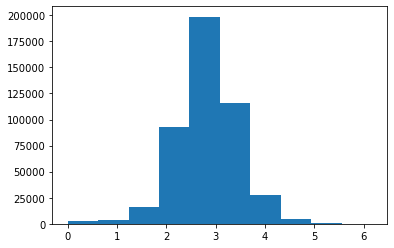

In [129]:
plt.hist(tweet_features[:,feature_to_col["follower_count"]])
plt.show()

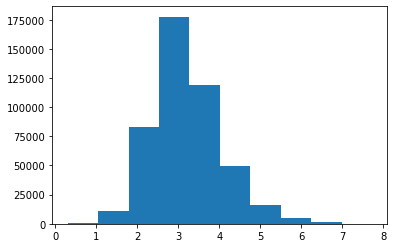

In [130]:
plt.hist(tweet_features[:,feature_to_col["following_count"]])
plt.show()

In [131]:
tweet_timestamps

array([1614207600, 1614207600, 1614207600, ..., 1614211199, 1614211199,
       1614211199])

In [132]:
tweet_features[0,:]

array([0.       , 0.       , 0.       , 0.       , 0.       , 1.       ,
       3.6028194, 3.817433 , 1.       , 1.       ], dtype=float32)

In [133]:
tweet_targets[0,:]

array([0., 0., 0., 1.], dtype=float32)

In [134]:
scaling = tweet_features.max(axis=0)
for i, (c, s) in enumerate(zip(feature_names, scaling)):
    print(i, c, s)

0 photo 1.0
1 video 1.0
2 link 1.0
3 retweet 1.0
4 quote 1.0
5 toplevel 1.0
6 follower_count 6.167881
7 following_count 7.7219787
8 verified 1.0
9 rel_engagement 4.0


In [135]:
# bring on same scale
#tweet_features = tweet_features / scaling.reshape((1,-1))

In [136]:
tweet_features.shape

(462701, 10)

In [137]:
tweet_features /= np.linalg.norm(tweet_features, axis=1).reshape(-1,1)

In [138]:
np.linalg.norm(tweet_features, axis=1)

array([1.        , 0.99999994, 1.        , ..., 1.        , 0.99999994,
       1.        ], dtype=float32)

In [139]:
tweet_features.dot(tweet_features[0,:])

array([1.        , 0.93883604, 0.9520716 , ..., 0.91096187, 0.9776503 ,
       0.9282817 ], dtype=float32)

In [140]:
similarities = tweet_features.dot(tweet_features[0,:])

In [141]:
topk = 20
amaxes = np.argpartition(similarities, -topk)[-topk:] # linear time
amaxes

array([394474, 214827, 450887, 169587,  29126, 319318,   3014,  54117,
       184192,  46031, 266746,   5331, 347052, 335048,  77966, 355213,
       341221, 240096,  50880,      0])

In [142]:
similarities[amaxes]

array([0.9999946 , 0.9999948 , 0.99999464, 0.9999954 , 0.9999958 ,
       0.999996  , 0.9999954 , 0.9999962 , 0.99999696, 0.9999996 ,
       0.99999934, 0.999997  , 0.99999624, 0.9999989 , 0.9999993 ,
       0.9999991 , 0.9999999 , 0.9999999 , 0.99999774, 1.        ],
      dtype=float32)

In [143]:
weights = similarities[amaxes]
weights /= np.abs(weights).sum()
weights

array([0.04999986, 0.04999987, 0.04999987, 0.0499999 , 0.04999993,
       0.04999993, 0.0499999 , 0.04999994, 0.04999998, 0.05000011,
       0.0500001 , 0.04999999, 0.04999994, 0.05000008, 0.0500001 ,
       0.05000009, 0.05000013, 0.05000013, 0.05000002, 0.05000013],
      dtype=float32)

In [144]:
tweet_targets[amaxes,:]

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [145]:
weights.reshape((-1,1))

array([[0.04999986],
       [0.04999987],
       [0.04999987],
       [0.0499999 ],
       [0.04999993],
       [0.04999993],
       [0.0499999 ],
       [0.04999994],
       [0.04999998],
       [0.05000011],
       [0.0500001 ],
       [0.04999999],
       [0.04999994],
       [0.05000008],
       [0.0500001 ],
       [0.05000009],
       [0.05000013],
       [0.05000013],
       [0.05000002],
       [0.05000013]], dtype=float32)

In [146]:
target_prediction = np.sum(tweet_targets[amaxes,:] * weights.reshape((-1,1)), axis=0)
target_prediction

array([0.09999999, 0.14999996, 0.        , 0.75000006], dtype=float32)

In [147]:
target_names

['rel_replies', 'rel_retweets', 'rel_quotes', 'rel_likes']

In [148]:
reply_pred, retweet_pred, quote_pred, fav_pred = target_prediction

In [156]:
def parse_input_line(row):
    tweet_id = row[all_features_to_idx['tweet_id']]
    user_id = row[all_features_to_idx['engaging_user_id']]
    
    input_feats = np.zeros((tweet_features.shape[1],),dtype=np.float32)
    
    media = row[all_features_to_idx["present_media"]]
    if "Photo" in media:
        input_feats[feature_to_col["photo"]] = 1

    if "Video" in media or "GIF" in media:
        input_feats[feature_to_col["video"]] = 1

    if row[all_features_to_idx["present_links"]] != "":
        input_feats[feature_to_col["link"]] = 1

    tweet_type = row[all_features_to_idx["tweet_type"]]
    if tweet_type == "TopLevel":
        input_feats[feature_to_col["toplevel"]] = 1
    elif tweet_type == "Quote":
        input_feats[feature_to_col["quote"]] = 1
    elif tweet_type == "Retweet":
        input_feats[feature_to_col["retweet"]] = 1

    input_feats[feature_to_col["follower_count"]] = int(row[all_features_to_idx["engaged_with_user_following_count"]])
    input_feats[feature_to_col["following_count"]] = int(row[all_features_to_idx["engaged_with_user_follower_count"]])
    input_feats[feature_to_col["verified"]] = bool(row[all_features_to_idx["engaged_with_user_is_verified"]])
    
    input_feats /= np.linalg.norm(input_feats)
            
    tweet_timestamp = row[all_features_to_idx['tweet_timestamp']]
    
    return tweet_id, user_id, input_feats, tweet_timestamp


def evaluate_test_set(path, dataset_type):
    expanded_path = os.path.expanduser(path)
    part_files = [os.path.join(expanded_path, f) for f in os.listdir(expanded_path) if dataset_type in f]
    part_files = sorted(part_files, key = lambda x:x[-5:]) 
        
    with open('results.csv', 'w') as output:
        for file in part_files:
            with open(file, 'r') as f:
                linereader = csv.reader(f, delimiter='\x01')
                last_timestamp = None
                for i, row in enumerate(linereader):
                    tweet_id, user_id, features, tweet_timestamp = parse_input_line(row) 
                    
                    if tweet_id in tweet_ids:
                        # allows more features, like rel_engagement, which are otherwise 0
                        features = tweet_features[tweet_ids[tweet_id], :] 
                    
                    similarities = tweet_features.dot(features)
                    
                    topk = 20
                    amaxes = np.argpartition(similarities, -topk)[-topk:] # linear time
                    
                    weights = similarities[amaxes]
                    weights /= np.abs(weights).sum()

                    target_prediction = np.sum(tweet_targets[amaxes,:] * weights.reshape((-1,1)), axis=0)
                    
                    reply_pred, retweet_pred, quote_pred, fav_pred = target_prediction

                    output.write(f'{tweet_id},{user_id},{reply_pred},{retweet_pred},{quote_pred},{fav_pred}\n')

                    if i % 1000 == 0:
                        print(i, end="\r")
                    i += 1
                
                print("Done!", end="\r")


In [157]:
%%time
evaluate_test_set(val_path_to_data, 'one_hour')

CPU times: user 18min 18s, sys: 51min 6s, total: 1h 9min 25s
Wall time: 9min 1s


In [158]:
def write_ground_truth(path, dataset_type):
    expanded_path = os.path.expanduser(path)
    part_files = [os.path.join(expanded_path, f) for f in os.listdir(expanded_path) if dataset_type in f]
    part_files = sorted(part_files, key = lambda x:x[-5:]) 
        
    with open('gt.csv', 'w') as output:
        for file in part_files:
            with open(file, 'r') as f:
                linereader = csv.reader(f, delimiter='\x01')
                last_timestamp = None
                for row in linereader:
                    tweet_id = row[all_features_to_idx['tweet_id']]
                    user_id = row[all_features_to_idx['engaging_user_id']]
                    
                    reply_pred = int(row[all_features_to_idx['reply']] != "") 
                    retweet_pred = int(row[all_features_to_idx['retweet']] != "")
                    quote_pred = int(row[all_features_to_idx['quote']] != "") 
                    fav_pred = int(row[all_features_to_idx['like']] != "") 
                    
                    
                    output.write(f'{tweet_id},{user_id},{reply_pred},{retweet_pred},{quote_pred},{fav_pred}\n')

In [159]:
write_ground_truth(val_path_to_data, 'one_hour')

In [162]:
def evaluate_zeroR_test_set(path, dataset_type):
    expanded_path = os.path.expanduser(path)
    part_files = [os.path.join(expanded_path, f) for f in os.listdir(expanded_path) if dataset_type in f]
    part_files = sorted(part_files, key = lambda x:x[-5:]) 
        
    with open('zeroR.csv', 'w') as output:
        for file in part_files:
            with open(file, 'r') as f:
                linereader = csv.reader(f, delimiter='\x01')
                last_timestamp = None
                for i, row in enumerate(linereader):
                    tweet_id = row[all_features_to_idx['tweet_id']]
                    user_id = row[all_features_to_idx['engaging_user_id']]
                    
                    reply_pred, retweet_pred, quote_pred, fav_pred = 0., 0., 0., 0.

                    output.write(f'{tweet_id},{user_id},{reply_pred},{retweet_pred},{quote_pred},{fav_pred}\n')

In [163]:
evaluate_zeroR_test_set(val_path_to_data, 'one_hour')

In [164]:
def read_predictions(path, col):
    pred_col = {"reply": 2, "retweet": 3, "quote": 4, "like": 5}[col]
    pred = pd.read_csv(path, header=None, usecols=[pred_col])
    return pred[pred_col].values

In [168]:
from sklearn.metrics import average_precision_score, log_loss

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])

    ctr = positive/float(len(gt))

    return ctr

def compute_rce(pred, gt):

    cross_entropy = log_loss(gt, pred)

    data_ctr = calculate_ctr(gt)

    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])

    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

ground_truth = read_predictions("gt.csv", "reply") # will return data in the form (tweet_id, user_id, labed (1 or 0))

predictions = read_predictions("results.csv", "reply") # will return data in the form (tweet_id, user_id, prediction)

rce = compute_rce(predictions, ground_truth)
print("rce:", rce)

average_precision = average_precision_score(ground_truth, predictions)
print("average_precision:", average_precision)

accuracy = np.mean(ground_truth == predictions)
print("accuracy:", accuracy)

rce: -233.43933830426766
average_precision: 0.018494913120772966
accuracy: 0.22894864714317884


#### zeroR
rce: -621.8494688006682  
average_precision: 0.02245872690425116  
accuracy: 0.9775412730957488  

#### item item
rce: -233.43933830426766  
average_precision: 0.018494913120772966  
accuracy: 0.22894864714317884

## Data Analysis

In [6]:
all_features_to_idx["tweet_id"], all_features_to_idx["engaged_with_user_id"], all_features_to_idx["engaging_user_id"]

(2, 9, 14)

In [7]:
ids_df = pd.read_csv(part_files[0], delimiter='\x01', header=None, usecols=[2, 9, 14], low_memory=True)
ids_df.columns = ["tweet_id", "engaged_with_user_id", "engaging_user_id"]

In [8]:
ids_df.memory_usage(deep=True).sum() / 1024**2

227.06659030914307

In [9]:
ids_df

,tweet_id,engaged_with_user_id,engaging_user_id
0,395A05A1E8A0A4CEB2E623281C7A41EE,55F619B7474C1BA0C8EE03C2A31C534C,736278C2FEC488516CDA4ED6952A2154
1,81E8247F4E74A0FCDBA911E1A3CB5412,9B49D384D56A65E00A12D8349EB46CE5,19D5367D835484236CAF9DBEF475FF7A
2,81E8247F4E74A0FCDBA911E1A3CB5412,9B49D384D56A65E00A12D8349EB46CE5,40BEB04CF8D3CB02449879668656FFDB
3,81E8247F4E74A0FCDBA911E1A3CB5412,9B49D384D56A65E00A12D8349EB46CE5,6415C94D3C27BA84C069DE049EBB3EDE
4,81E8247F4E74A0FCDBA911E1A3CB5412,9B49D384D56A65E00A12D8349EB46CE5,7E614D5881BC18768880CC374C4BE821
...,...,...,...
891742,FDD2D7997110248166FB05C2E8609696,37F269A3339E8ABF2B43B49DD9E13369,88A1D59A5ACB3CD87AFBCB58AFB33579
891743,BB1139C86AAB39557087F9B8BEA3D6A3,B8E7C8A003C8029246951612112971A7,7D704E0ECA4D89F47460049DADEBBD65
891744,D03C8A65EA0A1197483C9D9051F49BD4,E003E05842A204AE468B4414DF1438E1,58ED1F75F517E65F96C352C42C33E308
891745,24166BF0D0D45F2D811606E3417AE975,AC97A410ACCA49F55222D8AF5D86CA80,1B1C8C719C1BA40D5EE7DF756ACDF0AD


In [10]:
count = ids_df["tweet_id"].unique().shape[0]
count, ids_df.shape[0],  count/ ids_df.shape[0] * 100

(462701, 891747, 51.88702625296189)

In [11]:
count = ids_df["engaged_with_user_id"].unique().shape[0]
count, ids_df.shape[0], count/ ids_df.shape[0] * 100

(366489, 891747, 41.09786744446575)

In [12]:
count = ids_df["engaging_user_id"].unique().shape[0]
count, ids_df.shape[0], count/ ids_df.shape[0] * 100

(723876, 891747, 81.17504179997242)

In [13]:
count = np.unique(np.hstack((ids_df["engaged_with_user_id"].unique(), ids_df["engaging_user_id"].unique()))).shape[0]
count

1052526

In [14]:
tweet_counts = ids_df["tweet_id"].value_counts()
tweet_counts[:20]

0C41A44A186E4BC745B50808D14A503E    1281
4BF577D6457DE152C6D503030DD2ADFB    1182
03BA9C4C2886E2DB5D93AD3EC15FE3E6    1018
140907F4444EDDC0DA1BED731EC0D48F    1010
0397E6D2EB9382DC320FDA29E84F1B99     873
7396FF2779447D271A061D87FF0D028A     717
548EF0B837B4F004FC82A2C81EE217EB     675
BDDE5612FA98B16A8F15322D6DDBED9B     671
31780F9539DF8121EA75ACE57A03C97D     618
5617BE9B913D339571316EA793E4CBFA     565
8AC60BA9AF30546D02BF062ACECC93BD     496
119EF676F80A116833422C00CCE93A6A     477
3431819895B6F010FFB7FA4497424156     476
FC769FF328E1E66C275511C7473142A5     475
EC9EF9649D7DA549C0A0023A68B466B5     473
8DF546B64A4B804A64DD3679FD36E969     449
33A49915F0C8288AF441B1322BDB6044     448
A30326B359A208E3D989821784B8ED74     430
A8741D02F70400CBE3A5DA987C610A19     419
927FC8C18B08D2F21BF63817B32A3D14     407
Name: tweet_id, dtype: int64

In [15]:
for i in range(1,10):
    perc = tweet_counts[tweet_counts >= i].count() / tweet_counts.shape[0]
    print(i, perc)

1 1.0
2 0.22342074039174326
3 0.10189301514368891
4 0.06344918208519108
5 0.045696897132273324
6 0.0353014149526368
7 0.028575689268015413
8 0.023868545777942993
9 0.020460297254598542


In [16]:
user_counts = ids_df["engaging_user_id"].value_counts()
user_counts[:20]

A7A0D8C2BEA761E0E55973D6B8B3C71F    105
6F9CB26EE4BFE55B073C834F2766FD90     81
01FBD22853E9E46D01F0D2E9FEF7BA65     68
18B2A4E45369F14A45268FB570173670     62
245201C9F4097A9193C0EBE997739F6C     53
55DF9ECE4FE04818FFB782C70072DABF     52
12B8F01C0003E5DD4417DF065F0E704D     52
6FB283D6C0617559E7C0DC8B1800C764     50
AF35194E19554A40A9DEFBFAE63346D5     48
986577AE01099608DB21B5F698605EBD     48
376752C2E86F9A4294447F6BDA649372     47
496D0BDBB07709E3311F4D7B471793FB     47
7CFA32EFF00FEF66C668D0B3F62FFE71     47
CA12D95DD1E271754A64C68D0FEC75D4     45
987DFD4387198744F00EF3A2A8C26D14     44
D15190EEC763D70F1DF6020FC416B81A     44
47AE06912967213B7B710A38C1DDA165     44
110CFDAAF99ABCE46CB100C29C0FDD0A     43
1ED10D5860FF924206A04021D7A321CA     43
06DDC605C6B8922F130A02287AC322EE     42
Name: engaging_user_id, dtype: int64

In [17]:
for i in range(1,10):
    perc = user_counts[user_counts >= i].count() / user_counts.shape[0]
    print(i, perc)

1 1.0
2 0.1360564516574662
3 0.04275317872121744
4 0.018465869845111595
5 0.009823505683293824
6 0.006007935060701004
7 0.003927468240416867
8 0.0027960589935292785
9 0.0020846111764998426


In [18]:
val_path_to_data = '~/shared/data/project/validation/'
val_expanded_path = os.path.expanduser(val_path_to_data)
val_part_files = [os.path.join(val_expanded_path, f) for f in os.listdir(val_expanded_path) if dataset_type in f]
val_part_files = sorted(val_part_files, key = lambda x:x[-5:])
val_part_files

['/home/e01634838/shared/data/project/validation/one_hour']

In [19]:
val_data = pd.read_csv(val_part_files[0], delimiter='\x01', header=None, usecols=[2, 9, 14])
val_data.columns = ["tweet_id", "engaged_with_user_id", "engaging_user_id"]
val_data

,tweet_id,engaged_with_user_id,engaging_user_id
0,F1ACF09134D089766E7ED9599AF5BAAB,C5F5D3AAF8A8854AC28815834A964FDE,06581EA8BFF48387905AE44461A5E326
1,357F7ADACCC62DFE4239030C337E1203,9CDD3F511FED66B0683C9C7C991D7F53,8D4394F5025308A5EBD15E24A315378E
2,357F7ADACCC62DFE4239030C337E1203,9CDD3F511FED66B0683C9C7C991D7F53,DFA5260A0F9FE3D0F57D4BFC73EE0BE1
3,124572F51ECB70FB32FD236C0DCC49F9,8246DC1744B5D1B6B6CD5621D570C5FE,B61D0A5B8AA47718490FCB03757402BF
4,AF7BCBA32384842B8D5A5A165DE74A96,07384963D3B5683AC009A9B29747F07A,362F40E439E0C773A8DB308E6E673313
...,...,...,...
84372,2A0B4C59EC449EC4A7EA1771DDB888D8,A474957E420E330B28E82EAEBF9D099A,090719B8118D9D2F0CC010C4BA8648C8
84373,A533F79F65E5D277238C1DB40C9ADAAE,E9F297211EBAB2FB351C34D0B6FEAEEA,D27628FDF5CAE5C80295396D490A35C2
84374,8DFDF22F0D21CD5FD756896907282355,40AA0CEAE15AB1063B4E3343B0193569,66D49C65447407A5837A2C20510DF7B2
84375,0E0404A93580C173B67E0F921971A2EB,52424CF8261BC608F5C92A59DD3F21D5,FA314A78B5BFAEC6FC403D2C860752B9


In [20]:
len(set(val_data["engaging_user_id"].unique()).difference(set(user_counts.index.values))) / val_data.shape[0] * 100

88.61301065456226

In [21]:
len(set(val_data["tweet_id"].unique()).difference(set(tweet_counts.index.values))) / val_data.shape[0] * 100

69.08280692605805

In [ ]:
# hidden


In [ ]:
# feel free to edit

In [ ]:
# feel free to edit

In [ ]:
# feel free to edit

In [ ]:
# feel free to edit

In [ ]:
# feel free to edit

In [ ]:
# feel free to edit

In [ ]:
# feel free to edit

In [ ]:
# feel free to edit

In [ ]:
# feel free to edit